In [ ]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [ ]:
loyalty2 = pd.read_csv('/content/business_loyalty2 (1).csv')
print(loyalty2.shape)
print(loyalty2.columns)

(48047, 25)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'repeat_user_ratio',
       'repeat_user_avg_stars', 'regular_customer_score', 'checkin_count',
       'checkin_count_log', 'checkin_count_score', 'checkin_interval',
       'checkin_interval_log', 'checkin_interval_score', 'loyalty_score',
       'store_status'],
      dtype='object')


In [ ]:
reliability = pd.read_csv('/content/business_reliability (3).csv')
print(reliability.shape)
print(reliability.columns)

(19534, 20)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'StableIndex', 'RecoveryRate',
       'expert_scaled', 'elite_scaled', 'activity_scaled',
       'reliability_score'],
      dtype='object')


In [ ]:
business = reliability.merge(loyalty2[['business_id', 'store_status']], on='business_id', how='inner')

In [ ]:
print(business[['business_id', 'store_status', 'reliability_score']].head())

              business_id    store_status  reliability_score
0  MTSW4McQd7CbVtyjqoe9mw        open_old          64.011654
1  il_Ro8jwPlHresjw9EGmBg        open_old          48.460135
2  0bPLkL0QhhPO5kt1_EXmNQ  close_external          43.832936
3  MUTTqe8uqyMdBl186RmNeA        open_old          41.730439
4  ROeacJQwBeh05Rqg7F6TCg        open_old          43.424521


/tmp/ipython-input-3843118431.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='store_status')


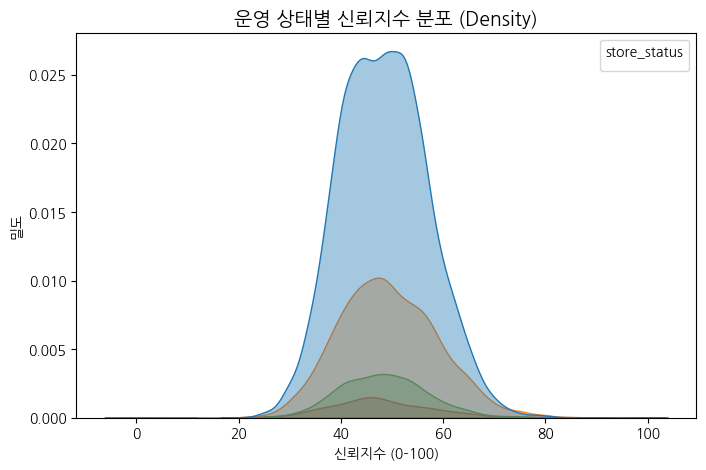

In [ ]:
df = business[['store_status', 'reliability_score']].dropna()
df = df[df['reliability_score'].between(0,100)]

plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='reliability_score', hue='store_status', fill=True, alpha=0.4)
plt.title('운영 상태별 신뢰지수 분포 (Density)', fontsize=14)
plt.xlabel('신뢰지수 (0–100)')
plt.ylabel('밀도')
plt.legend(title='store_status')
plt.show()

/tmp/ipython-input-4076574068.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


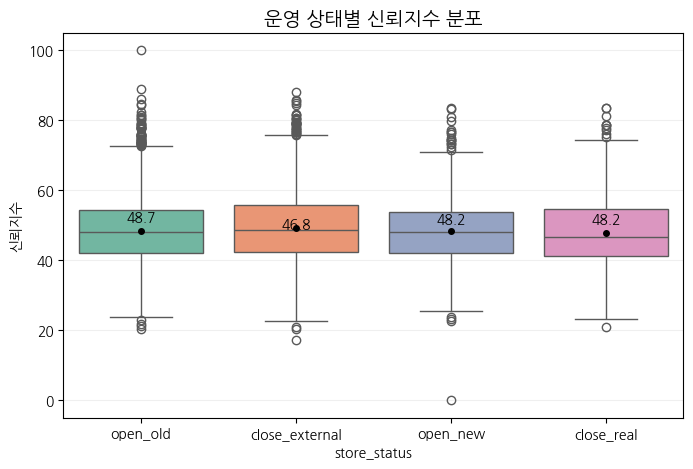

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(
    data=business,
    x='store_status',
    y='reliability_score',
    palette='Set2',
    showmeans=True,
    meanprops={'marker':'o', 'markerfacecolor':'black', 'markeredgecolor':'black', 'markersize':4}
)

plt.title('운영 상태별 신뢰지수 분포', fontsize=14)
plt.xlabel('store_status')
plt.ylabel('신뢰지수')
plt.grid(axis='y', alpha=0.2)
medians = business.groupby('store_status')['reliability_score'].median()
for i, (category, median) in enumerate(medians.items()):
    ax.text(i, median + 1.5,       # 위치 (x=그룹번호, y=중앙값보다 살짝 위)
            f'{median:.1f}',        # 소수점 1자리
            ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='black')

plt.show()
plt.show()

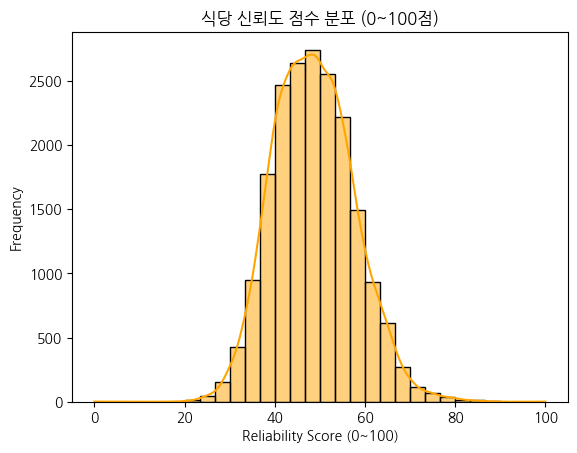

In [ ]:
sns.histplot(business['reliability_score'], bins=30, kde=True, color='orange', edgecolor='black')
plt.title('식당 신뢰도 점수 분포 (0~100점)')
plt.xlabel('Reliability Score (0~100)')
plt.ylabel('Frequency')
plt.show()

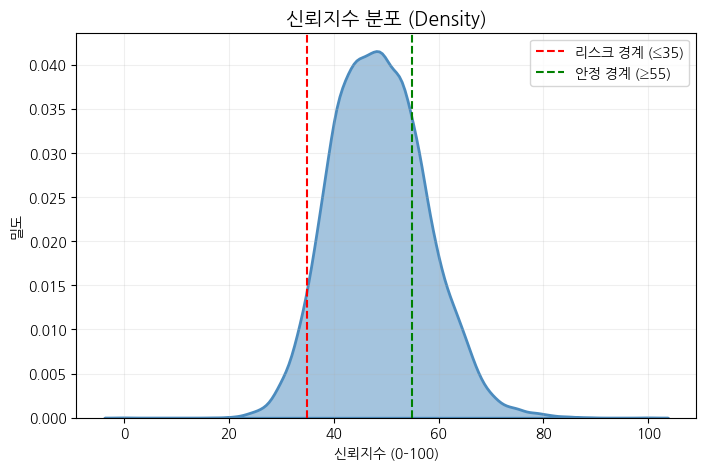

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=business,
    x='reliability_score',
    fill=True,
    color='#4B8BBE',   # 파이썬 블루 톤
    alpha=0.5,
    linewidth=2
)

# 리스크/안정 경계선 추가 (선택)
plt.axvline(35, color='red', linestyle='--', linewidth=1.5, label='리스크 경계 (≤35)')
plt.axvline(55, color='green', linestyle='--', linewidth=1.5, label='안정 경계 (≥55)')

# 그래프 꾸미기
plt.title('신뢰지수 분포 (Density)', fontsize=14)
plt.xlabel('신뢰지수 (0–100)')
plt.ylabel('밀도')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# 통계검증

In [ ]:
from scipy.stats import shapiro
shapiro(business['reliability_score'].sample(5000, random_state=42))  # pvalue=np.float64(2.945267560420078e-12)

ShapiroResult(statistic=np.float64(0.9949155984049494), pvalue=np.float64(2.945267560420078e-12))

In [ ]:
from scipy.stats import kruskal

groups = [g['reliability_score'].values for name, g in business.groupby('store_status')]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-stat={stat:.3f}, p-value={p:.5f}")

Kruskal-Wallis H-stat=29.945, p-value=0.00000


In [ ]:
from scipy.stats import mannwhitneyu

open = business[business['is_open']==1]['reliability_score']
closed = business[business['is_open']==0]['reliability_score']

stat, p = mannwhitneyu(closed, open, alternative='two-sided')
print(f"Mann-Whitney U={stat:.3f}, p-value={p:.5f}")

Mann-Whitney U=40223053.000, p-value=0.00008


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df['reliability_score'])
y = business['is_open']

model = sm.Logit(y, X).fit()
print(model.summary()) # Pseudo R-squ.: 0.001124

Optimization terminated successfully.
         Current function value: 0.596321
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                is_open   No. Observations:                19534
Model:                          Logit   Df Residuals:                    19532
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                0.001124
Time:                        01:30:59   Log-Likelihood:                -11649.
converged:                       True   LL-Null:                       -11662.
Covariance Type:            nonrobust   LLR p-value:                 3.052e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3619      0.087     15.587      0.000       1.191       1.533
reliabil

# 시각화

Text(0, 0.5, '매장 수')

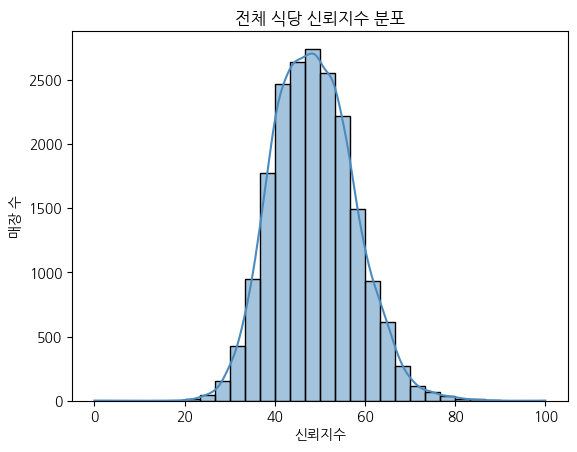

In [ ]:
sns.histplot(data=business, x='reliability_score', bins=30, kde=True, color='#4B8BBE')
plt.title('전체 식당 신뢰지수 분포')
plt.xlabel('신뢰지수')
plt.ylabel('매장 수')

- 완만한 종 모양의 정규형 -> 대부분의 식당의 신뢰지수가 평균 근처에 밀집
- 약 40~50점 근처가 중심, 전체 평균보다 낮거나 높은 극단값은 적음
- 약간 왼쪽 꼬리가 긴 형태
- 대다수 식당이 30~60점 사이에 있음

- 전체적으로 신뢰지수는 평균화된 지표
- 신뢰지수가 낮은 매장이 실제 폐업 위험군일 가능성이 높으므로 분위수별 폐업률 비교 가능

/tmp/ipython-input-1209988572.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=business, x='store_status', y='reliability_score', palette='Set2')


Text(0.5, 1.0, '운영 상태별 신뢰지수 분포')

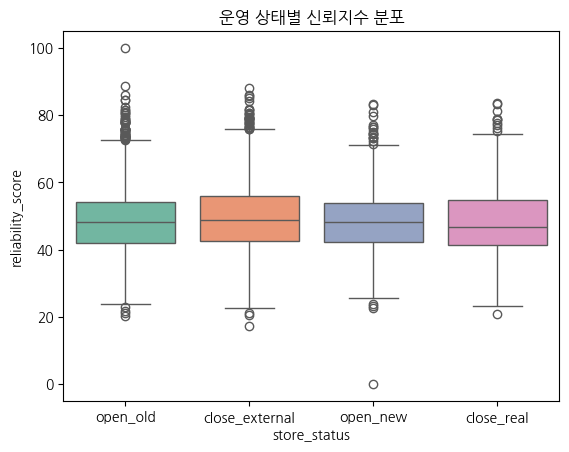

In [ ]:
sns.boxplot(data=business, x='store_status', y='reliability_score', palette='Set2')
plt.title('운영 상태별 신뢰지수 분포')

- open_old 그룹이 가장 안정적
- close_real은 변동성 높고 하단 이상치 많음

- 신뢰지수가 높은 매장이 반드시 오래되거나 영업 중인 건 아니지만, 운영이 오래된 매장은 신뢰도의 편차가 적고 안정적임을 보임
- 평균 수준은 비슷하지만 안정성이 다르다

<Axes: xlabel='reliability_score', ylabel='Density'>

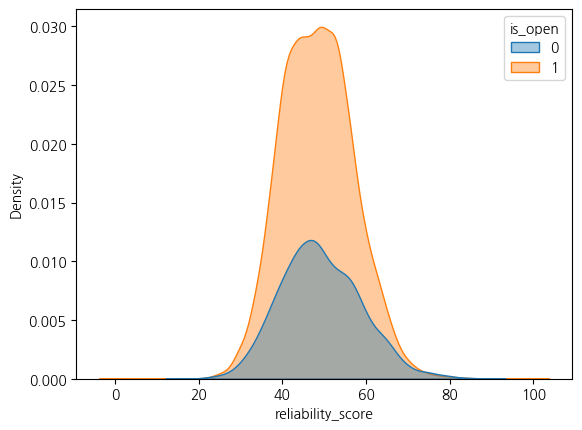

In [ ]:
sns.kdeplot(data=business, x='reliability_score', hue='is_open', fill=True, alpha=0.4)

- is_open=1 식당은 분포 중심이 약간 오른쪽
- is_open=0 식당은 왼쪽에 중심이 있음

- 폐업한 매장이 평균적으로 신뢰지수가 낮음
- 완전한 분리는 아니지만, 신뢰지수는 폐업 여부의 약한 에측 요인으로 작용

Text(0.5, 1.0, '신뢰지수와 폐업 확률의 관계 (로지스틱 곡선)')

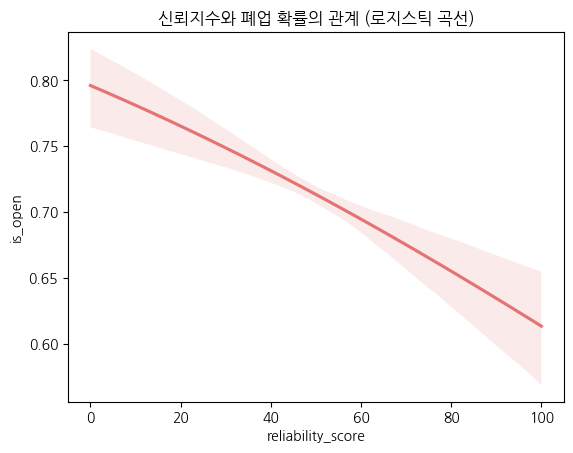

In [ ]:
sns.regplot(
    data=business,
    x='reliability_score',
    y='is_open',
    logistic=True,
    scatter=False,
    color='#E57373'
)
plt.title('신뢰지수와 폐업 확률의 관계 (로지스틱 곡선)')

- 회귀선은 우하향 형태 -> 신뢰지수↑ -> 폐업확률↓
- 신뢰지수 0~100 사이에서 비교적 선형적 감소 경향 보임
- 신뢰지수가 50점 이상부터 폐업확률 급감, 이후 완만해짐

- 가설 '신뢰지수가 높을수록 폐업확률이 낮다'를 시각적으로 입중
- 신뢰지수는 폐업 예측의 리스크 스코어로 기능할 수 있음

Text(0.5, 1.0, '신뢰지수 분위수별 폐업률 (%)')

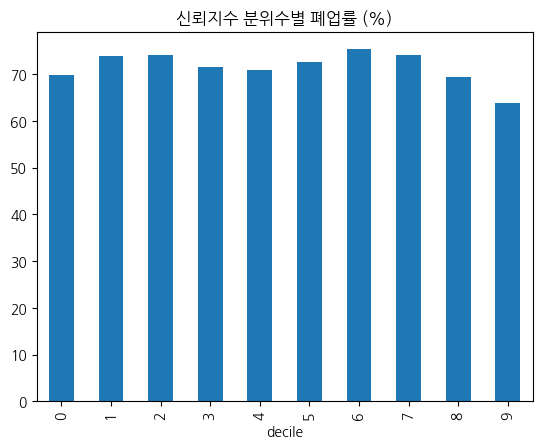

In [ ]:
business['decile'] = pd.qcut(business['reliability_score'], 10, labels=False)
decile_table = business.groupby('decile')['is_open'].mean()*100
decile_table.plot(kind='bar')
plt.title('신뢰지수 분위수별 폐업률 (%)')

<Axes: xlabel='reliability_score', ylabel='stars'>

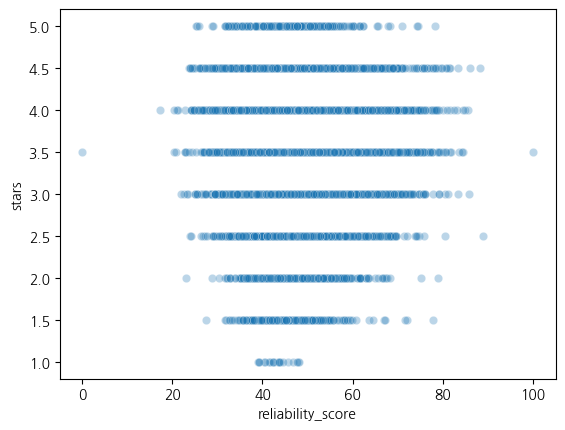

In [ ]:
sns.scatterplot(data=business, x='reliability_score', y='stars', alpha=0.3)

- 별점은 1~5 사이에서 수평 분포
- 신뢰지수는 별점 구간 내에서도 다양하게 분포함 -> 직선적 관계 거의 없음

- 신뢰지수는 단순한 별점 요약이 아니라, 리뷰의 품질, 리뷰어 신뢰도, 활동성 등 복합 요소가 반영된 지표임을 보여줌
- 별점이 높더라도 신뢰지수가 낮을 수 있음 -> 별점과는 다른 차원의 평판 지표

# 운영상태에 따른 신뢰점수

In [ ]:
for s in df['store_status'].unique():
    stat, p = shapiro(df.loc[df['store_status']==s, 'reliability_score'])
    print(s, p)

open_old 2.328429669901794e-19
close_external 3.8280603591106803e-13
open_new 1.011526786567074e-08
close_real 2.4543108087058095e-06


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12588.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
from scipy.stats import levene
groups = [df.loc[df['store_status']==s, 'reliability_score'] for s in df['store_status'].unique()]
stat, p = levene(*groups)
print(f"Levene’s Test p={p:.5f}")

Levene’s Test p=0.00000


정규성 + 등분산성 위배

In [ ]:
from scipy.stats import kruskal

groups = [
    df.loc[df['store_status'] == 'open_old', 'reliability_score'],
    df.loc[df['store_status'] == 'close_external', 'reliability_score'],
    df.loc[df['store_status'] == 'open_new', 'reliability_score'],
    df.loc[df['store_status'] == 'close_real', 'reliability_score']
]

stat, p = kruskal(*groups)
print(f"Kruskal–Wallis H-stat = {stat:.3f}, p-value = {p:.5f}")

Kruskal–Wallis H-stat = 29.945, p-value = 0.00000


운영 상태별 신뢰지수 분포에 유의한 차이가 있음 → 적어도 한 그룹이 다름

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import pandas as pd

results = []
for g1, g2 in combinations(df['store_status'].unique(), 2):
    data1 = df.loc[df['store_status']==g1, 'reliability_score']
    data2 = df.loc[df['store_status']==g2, 'reliability_score']
    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    results.append([g1, g2, stat, p])

posthoc_df = pd.DataFrame(results, columns=['Group 1', 'Group 2', 'U-stat', 'p-value'])
posthoc_df['p-value_adj'] = posthoc_df['p-value'] * len(posthoc_df)  # Bonferroni 보정
posthoc_df.sort_values('p-value_adj')

,Group 1,Group 2,U-stat,p-value,p-value_adj
0,open_old,close_external,29462075.0,0.000001,0.000009
4,close_external,close_real,1717842.0,0.000279,0.001672
3,close_external,open_new,3580434.0,0.006737,0.040420
2,open_old,close_real,4235150.0,0.046466,0.278798
5,open_new,close_real,468964.0,0.081957,0.491741
1,open_old,open_new,8770472.0,0.948530,5.691177


1. 신뢰지수가 높은 그룹
- open_old과 close_external가 상대적으로 높음
- 매장 내부 운영 품질 측면에서 안정적인 그룹

2 신뢰지수가 낮은 그룹
- close_real과 open_new
- 신뢰 형성이 덜 되었거나, 실제 경영 문제로 신뢰도 하락

3. 차이
open_ole > close_external > open_new ≈ close_real
- 신뢰지수는 운영 경험 (시간)과 안정성과 양의 관계
- 경영악화형 폐업과 신규 매장은 모두 신뢰도가 낮은 공통점이 있음

인사이트
1. 오래된 매장은 신뢰도 유지력이 높다
- 오랜 운영 경험과 리뷰 품질 축적으로 안정적인 신뢰 확보
2. 외부 요인 폐업은 내부 신뢰 문제와 무관
- 정책, 입지 등 외생 요인에 으한 폐업 가능성
3. 신규 매장과 실제 폐업 매장은 신뢰지수 하위
- 신뢰도 형성이 초기 단계이거나, 서비스 품질 저하로 인한 평판 악화
4. 신뢰지수는 매장 생존력의 지표로 유효
- 운영상태에 따른 유의한 차이가 통계적으로 입증 (p<0.05)